#Downloading the dataset

In [ ]:
!pip install --upgrade --no-cache-dir gdown

  Attempting uninstall: gdown
    Found existing installation: gdown 4.6.6
    Uninstalling gdown-4.6.6:
      Successfully uninstalled gdown-4.6.6


In [ ]:
import gdown
!gdown --fuzzy https://drive.google.com/file/d/1wEc5liKTpiTnugwqKqIXy4qzcrV0eRpG/view?usp=sharing

Downloading...
From (uriginal): https://drive.google.com/uc?id=1wEc5liKTpiTnugwqKqIXy4qzcrV0eRpG
From (redirected): https://drive.google.com/uc?id=1wEc5liKTpiTnugwqKqIXy4qzcrV0eRpG&confirm=t&uuid=8ca85e86-ccf8-4c7b-962e-37220e8a953e
To: /content/archive (3).zip
100% 693M/693M [00:10<00:00, 65.8MB/s]


In [ ]:
import gdown
!gdown --fuzzy https://drive.google.com/file/d/1HuCXt44cuprBbz9z3rl3TxnXAfM_wMPG/view?usp=sharing

Downloading...
From (uriginal): https://drive.google.com/uc?id=1HuCXt44cuprBbz9z3rl3TxnXAfM_wMPG
From (redirected): https://drive.google.com/uc?id=1HuCXt44cuprBbz9z3rl3TxnXAfM_wMPG&confirm=t&uuid=43e8c827-62c5-4d12-96a7-44a709e755f2
To: /content/rec2023.zip
100% 1.93G/1.93G [00:24<00:00, 77.3MB/s]


In [ ]:
!unzip /content/archive.zip

Archive:  /content/archive.zip
  inflating: anime.csv               
  inflating: anime_with_synopsis.csv  
  inflating: animelist.csv           
  inflating: html folder/html/1/details.html  
  inflating: html folder/html/1/pictures.html  
  inflating: html folder/html/1/recomendations.html  
  inflating: html folder/html/1/reviews_1.html  
  inflating: html folder/html/1/reviews_10.html  
  inflating: html folder/html/1/reviews_11.html  
  inflating: html folder/html/1/reviews_12.html  
  inflating: html folder/html/1/reviews_13.html  
  inflating: html folder/html/1/reviews_14.html  
  inflating: html folder/html/1/reviews_15.html  
  inflating: html folder/html/1/reviews_16.html  
  inflating: html folder/html/1/reviews_17.html  
  inflating: html folder/html/1/reviews_18.html  
  inflating: html folder/html/1/reviews_19.html  
  inflating: html folder/html/1/reviews_2.html  
  inflating: html folder/html/1/reviews_20.html  
  inflating: html folder/html/1/reviews_21.html  
  infla

In [ ]:
!unzip /content/rec2023.zip

Archive:  /content/rec2023.zip
  inflating: anime-dataset-2023.csv  
  inflating: anime-filtered.csv      
  inflating: final_animedataset.csv  
  inflating: user-filtered.csv       
  inflating: users-details-2023.csv  
  inflating: users-score-2023.csv    


#Importing the necessary libaries

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import pickle
import warnings
warnings.filterwarnings(action='ignore')

In [ ]:
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import LabelEncoder

In [ ]:
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split
import tensorflow as tf

In [ ]:
from tensorflow.keras.layers import Input, Embedding, Dot, Flatten, Dense
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from wordcloud import WordCloud
from collections import defaultdict
from collections import Counter

In [ ]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import linear_kernel

#Data pre-processing

In [ ]:
df=pd.read_csv('/content/users-score-2023.csv', usecols=["user_id","anime_id","rating"])
print("Shape of the Dataset:",df.shape)
df.head()

Shape of the Dataset: (24325191, 3)


,user_id,anime_id,rating
0,1,21,9
1,1,48,7
2,1,320,5
3,1,49,8
4,1,304,8


In [ ]:
duplicated_rows = df[df.duplicated()]
print("Duplicated Rows:")
print(duplicated_rows)

Duplicated Rows:
Empty DataFrame
Columns: [user_id, anime_id, rating]
Index: []


In [ ]:
avg_score = np.mean(df['rating'])
print('Average Score:', avg_score)

Average Score: 7.622930072779285


In [ ]:
scaler = MinMaxScaler(feature_range=(0, 1))

# Scale the 'score' column between 0 and 1
df['scaled_score'] = scaler.fit_transform(df[['rating']])

In [ ]:
# Encoding categorical data

## Encoding user IDs
user_encoder = LabelEncoder()
df["user_encoded"] = user_encoder.fit_transform(df["user_id"])
num_users = len(user_encoder.classes_)

## Encoding anime IDs
anime_encoder = LabelEncoder()
df["anime_encoded"] = anime_encoder.fit_transform(df["anime_id"])
num_animes = len(anime_encoder.classes_)

# Printing dataset information
print("Number of unique users: {}, Number of unique anime: {}".format(num_users, num_animes))
print("Minimum rating: {}, Maximum rating: {}".format(min(df['rating']), max(df['rating'])))

Number of unique users: 270033, Number of unique anime: 16500
Minimum rating: 1, Maximum rating: 10


#Collaborative filtering

In [ ]:
# Shuffle the dataset
df = shuffle(df, random_state=100)

# Create feature matrix X and target variable y
X = df[['user_encoded', 'anime_encoded']].values
y = df["scaled_score"].values

# Printing dataset information
print("Shape of X:", X.shape)
print("Shape of y:", y.shape)

Shape of X: (24325191, 2)
Shape of y: (24325191,)


In [ ]:
test_set_size = 10000  # Number of samples to include in the test set

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_set_size, random_state=73)

print("Number of samples in the training set:", len(y_train))
print("Number of samples in the test set:", len(y_test))

Number of samples in the training set: 24315191
Number of samples in the test set: 10000


In [ ]:
#  input data for model training and evaluation
X_train_array = [X_train[:, 0], X_train[:, 1]]
X_test_array = [X_test[:, 0], X_test[:, 1]]

In [ ]:
def RecommenderNet(num_users, num_animes, embedding_size=128):
    #  input layer and embedding layer
    user = Input(name='user_encoded', shape=[1])
    user_embedding = Embedding(name='user_embedding', input_dim=num_users, output_dim=embedding_size)(user)

    # Anime input layer and embedding layer
    anime = Input(name='anime_encoded', shape=[1])
    anime_embedding = Embedding(name='anime_embedding', input_dim=num_animes, output_dim=embedding_size)(anime)

    # Dot product of user and anime embeddings
    dot_product = Dot(name='dot_product', normalize=True, axes=2)([user_embedding, anime_embedding])
    flattened = Flatten()(dot_product)

    # Dense layers for prediction
    dense = Dense(64, activation='relu')(flattened)
    output = Dense(1, activation='sigmoid')(dense)

    # Create and compile the model
    model = Model(inputs=[user, anime], outputs=output)
    model.compile(loss='binary_crossentropy', optimizer=Adam(learning_rate=0.001), metrics=["mae", "mse"])

    return model

In [ ]:
model = RecommenderNet(num_users, num_animes)

In [ ]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 user_encoded (InputLayer)   [(None, 1)]                  0         []                            
                                                                                                  
 anime_encoded (InputLayer)  [(None, 1)]                  0         []                            
                                                                                                  
 user_embedding (Embedding)  (None, 1, 128)               3456422   ['user_encoded[0][0]']        
                                                          4                                       
                                                                                                  
 anime_embedding (Embedding  (None, 1, 128)               2112000   ['anime_encoded[0][0]']   

In [ ]:
from tensorflow.keras.callbacks import ModelCheckpoint, LearningRateScheduler, EarlyStopping

In [ ]:
start_lr = 0.00001

In [ ]:
lr_callback = LearningRateScheduler(lambda epoch: lrfn(epoch), verbose=0)

In [ ]:
checkpoint_filepath = 'myanimeweights.h5'

In [ ]:
model_checkpoints = ModelCheckpoint(filepath=checkpoint_filepath,
                                    save_weights_only=True,
                                    monitor='val_loss',
                                    mode='min',
                                    save_best_only=True)

In [ ]:
early_stopping = EarlyStopping(patience=3, monitor='val_loss', mode='min', restore_best_weights=True)


In [ ]:
my_callbacks = [
    model_checkpoints,
    lr_callback,
    early_stopping
]

In [ ]:
history = model.fit(
    x=X_train_array,
    y=y_train,
    batch_size=batch_size,
    epochs=20,
    verbose=1,
    validation_data=(X_test_array, y_test),
    callbacks=my_callbacks
)

Epoch 1/20
2432/2432 [==============================] - 108s 38ms/step - loss: 0.6748 - mae: 0.2469 - mse: 0.0805 - val_loss: 0.6565 - val_mae: 0.2288 - val_mse: 0.0711 - lr: 1.0000e-05
Epoch 2/20
2432/2432 [==============================] - 53s 22ms/step - loss: 0.6259 - mae: 0.2001 - mse: 0.0565 - val_loss: 0.5995 - val_mae: 0.1719 - val_mse: 0.0435 - lr: 1.8000e-05
Epoch 3/20
2432/2432 [==============================] - 53s 22ms/step - loss: 0.5837 - mae: 0.1534 - mse: 0.0368 - val_loss: 0.5770 - val_mae: 0.1465 - val_mse: 0.0335 - lr: 2.6000e-05
Epoch 4/20
2432/2432 [==============================] - 53s 22ms/step - loss: 0.5755 - mae: 0.1440 - mse: 0.0334 - val_loss: 0.5735 - val_mae: 0.1408 - val_mse: 0.0322 - lr: 3.4000e-05
Epoch 5/20
2432/2432 [==============================] - 54s 22ms/step - loss: 0.5607 - mae: 0.1286 - mse: 0.0278 - val_loss: 0.5574 - val_mae: 0.1242 - val_mse: 0.0261 - lr: 4.2000e-05
Epoch 6/20
2432/2432 [==============================] - 53s 22ms/step - lo

In [ ]:
model.load_weights(checkpoint_filepath)

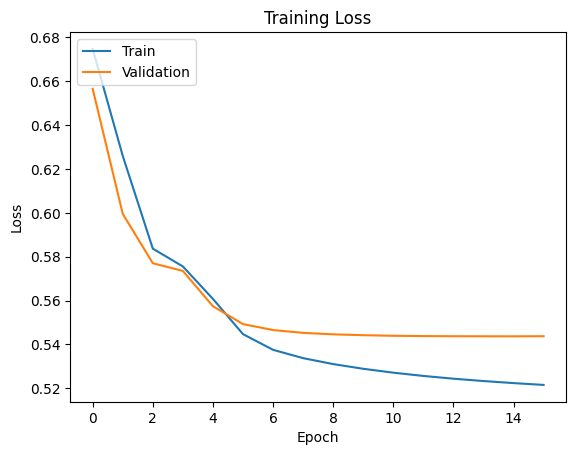

In [ ]:
plt.plot(history.history["loss"][0:-2])
plt.plot(history.history["val_loss"][0:-2])
plt.title("Training Loss")
plt.ylabel("Loss")
plt.xlabel("Epoch")
plt.legend(["Train", "Validation"], loc="upper left")
plt.show()

In [ ]:
def extract_weights(name, model):
    # Get the layer by name from the model
    weight_layer = model.get_layer(name)

    # Get the weights from the layer
    weights = weight_layer.get_weights()[0]

    # Normalize the weights
    weights = weights / np.linalg.norm(weights, axis=1).reshape((-1, 1))

    return weights

# Extract weights for anime embeddings
anime_weights = extract_weights('anime_embedding', model)
# Extract weights for user embeddings
user_weights = extract_weights('user_embedding', model)

In [ ]:
df_anime=pd.read_csv('/content/anime-dataset-2023.csv')

Now I want my model to recommend only those animes that have been rated by at least a certain number of users, which I will set as the threshold. This threshold helps ensure that the recommended anime titles have received a sufficient number of ratings, indicating a certain level of popularity or user engagement.

In [ ]:
popularity_threshold = 50
df_anime= df_anime.query('Members >= @popularity_threshold')
print(df_anime.shape)
df_anime.head(3)

(22879, 24)


,anime_id,Name,English name,Other name,Score,Genres,Synopsis,Type,Episodes,Aired,...,Studios,Source,Duration,Rating,Rank,Popularity,Favorites,Scored By,Members,Image URL
0,1,Cowboy Bebop,Cowboy Bebop,カウボーイビバップ,8.75,"Action, Award Winning, Sci-Fi","Crime is timeless. By the year 2071, humanity ...",TV,26.0,"Apr 3, 1998 to Apr 24, 1999",...,Sunrise,Original,24 min per ep,R - 17+ (violence & profanity),41.0,43,78525,914193.0,1771505,https://cdn.myanimelist.net/images/anime/4/196...
1,5,Cowboy Bebop: Tengoku no Tobira,Cowboy Bebop: The Movie,カウボーイビバップ 天国の扉,8.38,"Action, Sci-Fi","Another day, another bounty—such is the life o...",Movie,1.0,"Sep 1, 2001",...,Bones,Original,1 hr 55 min,R - 17+ (violence & profanity),189.0,602,1448,206248.0,360978,https://cdn.myanimelist.net/images/anime/1439/...
2,6,Trigun,Trigun,トライガン,8.22,"Action, Adventure, Sci-Fi","Vash the Stampede is the man with a $$60,000,0...",TV,26.0,"Apr 1, 1998 to Sep 30, 1998",...,Madhouse,Manga,24 min per ep,PG-13 - Teens 13 or older,328.0,246,15035,356739.0,727252,https://cdn.myanimelist.net/images/anime/7/203...


##Item Based Recommendation

In [ ]:
def find_similar_animes(name, n=10, return_dist=False, neg=False):
    try:
        anime_row = df_anime[df_anime['Name'] == name].iloc[0]
        index = anime_row['anime_id']
        encoded_index = anime_encoder.transform([index])[0]
        weights = anime_weights
        dists = np.dot(weights, weights[encoded_index])
        sorted_dists = np.argsort(dists)
        n = n + 1
        if neg:
            closest = sorted_dists[:n]
        else:
            closest = sorted_dists[-n:]
        print('Animes closest to {}'.format(name))
        if return_dist:
            return dists, closestm

        SimilarityArr = []

        for close in closest:
            decoded_id = anime_encoder.inverse_transform([close])[0]
            anime_frame = df_anime[df_anime['anime_id'] == decoded_id]

            anime_name = anime_frame['Name'].values[0]
            english_name = anime_frame['English name'].values[0]
            name = english_name if english_name != "UNKNOWN" else anime_name
            genre = anime_frame['Genres'].values[0]
            Synopsis = anime_frame['Synopsis'].values[0]
            similarity = dists[close]
            similarity = "{:.2f}%".format(similarity * 100)
            SimilarityArr.append({"Name": name, "Similarity": similarity, "Genres": genre, "Synopsis":Synopsis})
        Frame = pd.DataFrame(SimilarityArr).sort_values(by="Similarity", ascending=False)
        return Frame[Frame.Name != name]
    except:
        print('{} not found in Anime list'.format(name))

pd.set_option('display.max_colwidth', None)


In [ ]:
find_similar_animes('Tensei shitara Slime Datta Ken', n=5, neg=False)# that is That Time I Got Reincarnated as a Slime

Animes closest to Tensei shitara Slime Datta Ken


,Name,Similarity,Genres,Synopsis
4,That Time I Got Reincarnated as a Slime Season 2,84.19%,"Action, Adventure, Comedy, Fantasy","Taking a break from his time as a teacher, the powerful slime Rimuru Tempest returns to his kingdom, eponymously named Tempest, just in time to begin negotiations with a nearby nation—the Kingdom of Eurazania. While the negotiations are anything but peaceful, they do end successfully, allowing Rimuru to return and finish teaching. When trying to again return to Tempest, this time permanently, Rimuru is stopped by a mysterious figure who is somehow able to constrain the many magical abilities he has at his disposal. \n\nIn Tempest, the situation is even worse. A group of unknown humans has invaded the land and are assaulting its citizens, both influential and innocent. They are not just trying to bring harm either—they have the intent to kill. Can Rimuru overcome his powerful and dangerous foe and return to Tempest before it is too late?"
3,That Time I Got Reincarnated as a Slime Season 2 Part 2,77.09%,"Action, Adventure, Comedy, Fantasy","The nation of Tempest is in a festive mood after successfully overcoming the surprise attack from the Falmuth Army and the Western Holy Church. Beyond the festivities lies a meeting between Tempest and its allies to decide the future of the Nation of Monsters. The aftermath of the Falmuth invasion, Milim Nava's suspicious behavior, and the disappearance of Demon Lord Carrion—the problems seem to keep on piling up.\n\nRimuru Tempest, now awakened as a ""True Demon Lord,"" decides to go on the offensive against Clayman. With the fully revived ""Storm Dragon"" Veldora, ""Ultimate Skill"" Raphael, and other powerful comrades, the ruler of the Tempest is confident in taking down his enemies one by one until he can face the man pulling the strings."
2,My Hero Academia Season 3,75.03%,Action,"As summer arrives for the students at UA Academy, each of these superheroes-in-training puts in their best efforts to become renowned heroes. They head off to a forest training camp run by UA's pro heroes, where the students face one another in battle and go through dangerous tests, improving their abilities and pushing past their limits. However, their school trip is suddenly turned upside down when the League of Villains arrives, invading the camp with a mission to capture one of the students. \n\nBoku no Hero Academia 3rd Season follows Izuku ""Deku"" Midoriya, an ambitious student training to achieve his dream of becoming a hero similar to his role model—All Might. Being one of the students caught up amidst the chaos of the villain attack, Deku must take a stand with his classmates and fight for their survival."
1,My Hero Academia Season 2,73.33%,Action,"At UA Academy, not even a violent attack can disrupt their most prestigious event: the school sports festival. Renowned across Japan, this festival is an opportunity for aspiring heroes to showcase their abilities, both to the public and potential recruiters.\n\nHowever, the path to glory is never easy, especially for Izuku Midoriya—whose quirk possesses great raw power but is also cripplingly inefficient. Pitted against his talented classmates, such as the fire and ice wielding Shouto Todoroki, Izuku must utilize his sharp wits and master his surroundings to achieve victory and prove to the world his worth."
0,Your Lie in April,72.77%,"Drama, Romance","Kousei Arima is a child prodigy known as the ""Human Metronome"" for playing the piano with precision and perfection. Guided by a strict mother and rigorous training, Kousei dominates every competition he enters, earning the admiration of his musical peers and praise from audiences. When his mother suddenly passes away, the subsequent trauma makes him unable to hear the sound of a piano, and he never takes the stage thereafter.\n\nNowadays, Kousei lives a quiet and unassuming life as a junior high school student alongside his friends Tsubaki Sawabe and Ryouta Watari. While struggli

In [ ]:
find_similar_animes('Shigatsu wa Kimi no Uso', n=5, neg=False) # Your Lie in April

Animes closest to Shigatsu wa Kimi no Uso


,Name,Similarity,Genres,Synopsis
4,ERASED,88.00%,"Mystery, Supernatural, Suspense","When tragedy is about to strike, Satoru Fujinuma finds himself sent back several minutes before the accident occurs. The detached, 29-year-old manga artist has taken advantage of this powerful yet mysterious phenomenon, which he calls ""Revival,"" to save many lives.\n \nHowever, when he is wrongfully accused of murdering someone close to him, Satoru is sent back to the past once again, but this time to 1988, 18 years in the past. Soon, he realizes that the murder may be connected to the abduction and killing of one of his classmates, the solitary and mysterious Kayo Hinazuki, that took place when he was a child. This is his chance to make things right.\n \nBoku dake ga Inai Machi follows Satoru in his mission to uncover what truly transpired 18 years ago and prevent the death of his classmate while protecting those he cares about in the present."
3,Your Name.,87.40%,"Award Winning, Drama, Supernatural","Mitsuha Miyamizu, a high school girl, yearns to live the life of a boy in the bustling city of Tokyo—a dream that stands in stark contrast to her present life in the countryside. Meanwhile in the city, Taki Tachibana lives a busy life as a high school student while juggling his part-time job and hopes for a future in architecture.\n\nOne day, Mitsuha awakens in a room that is not her own and suddenly finds herself living the dream life in Tokyo—but in Taki's body! Elsewhere, Taki finds himself living Mitsuha's life in the humble countryside. In pursuit of an answer to this strange phenomenon, they begin to search for one another.\n\nKimi no Na wa. revolves around Mitsuha and Taki's actions, which begin to have a dramatic impact on each other's lives, weaving them into a fabric held together by fate and circumstance."
2,A Silent Voice,85.63%,"Award Winning, Drama","As a wild youth, elementary school student Shouya Ishida sought to beat boredom in the cruelest ways. When the deaf Shouko Nishimiya transfers into his class, Shouya and the rest of his class thoughtlessly bully her for fun. However, when her mother notifies the school, he is singled out and blamed for everything done to her. With Shouko transferring out of the school, Shouya is left at the mercy of his classmates. He is heartlessly ostracized all throughout elementary and middle school, while teachers turn a blind eye.\n\nNow in his third year of high school, Shouya is still plagued by his wrongdoings as a young boy. Sincerely regretting his past actions, he sets out on a journey of redemption: to meet Shouko once more and make amends.\n\nKoe no Katachi tells the heartwarming tale of Shouya's reunion with Shouko and his honest attempts to redeem himself, all while being continually haunted by the shadows of his past."
1,Steins;Gate: The Movie - Load Region of Déjà Vu,85.54%,"Drama, Sci-Fi","After a year in America, Kurisu Makise returns to Akihabara and reunites with Rintarou Okabe. However, their reunion is cut short when Okabe begins to experience recurring flashes of other timelines as the consequences of his time traveling start to manifest. These side effects eventually culminate in Okabe suddenly vanishing from the world, and only the startled Kurisu has any memory of his existence.\n\nIn the midst of despair, Kurisu is faced with a truly arduous choice that will test both her duty as a scientist and her loyalty as a friend: follow Okabe's advice and stay away from traveling through time to avoid the potential consequences it may have on the world lines, or ignore it to rescue the person that she cherishes most. Regardless of her decision, the path she chooses is one that will affect the past, the present, and the future."
0,Bakuman Season 3,84.86%,"Comedy, Drama, Romance","Onto their third serialization, manga duo Moritaka Mashiro and Akito Takagi—also known by their pen name, Muto Ashirogi—are ever closer to their dream of an anime adaption. However, the real challenge is onl

In [ ]:
find_similar_animes('One Punch Man', n=5, neg=False)

Animes closest to One Punch Man


,Name,Similarity,Genres,Synopsis
3,Haikyu!! 3rd Season,88.16%,Sports,"After the victory against Aoba Jousai High, Karasuno High School, once called “a fallen powerhouse, a crow that can’t fly,” has finally reached the climax of the heated Spring tournament. Now, to advance to nationals, the Karasuno team has to defeat the powerhouse Shiratorizawa Academy. Karasuno’s greatest hurdle is their adversary’s ace, Wakatoshi Ushijima, the number one player in the Miyagi Prefecture, and one of the country’s top three aces.\n\nOnly the strongest team will make it to the national tournament. Since this match is the third-year players’ last chance to qualify for nationals, Karasuno has to use everything they learned during the training camp and prior matches to attain victory. Filled with restlessness and excitement, both teams are determined to come out on top in the third season of Haikyuu!!."
4,Your Name.,88.16%,"Award Winning, Drama, Supernatural","Mitsuha Miyamizu, a high school girl, yearns to live the life of a boy in the bustling city of Tokyo—a dream that stands in stark contrast to her present life in the countryside. Meanwhile in the city, Taki Tachibana lives a busy life as a high school student while juggling his part-time job and hopes for a future in architecture.\n\nOne day, Mitsuha awakens in a room that is not her own and suddenly finds herself living the dream life in Tokyo—but in Taki's body! Elsewhere, Taki finds himself living Mitsuha's life in the humble countryside. In pursuit of an answer to this strange phenomenon, they begin to search for one another.\n\nKimi no Na wa. revolves around Mitsuha and Taki's actions, which begin to have a dramatic impact on each other's lives, weaving them into a fabric held together by fate and circumstance."
2,Hunter x Hunter,85.68%,"Action, Adventure, Fantasy","Hunters devote themselves to accomplishing hazardous tasks, all from traversing the world's uncharted territories to locating rare items and monsters. Before becoming a Hunter, one must pass the Hunter Examination—a high-risk selection process in which most applicants end up handicapped or worse, deceased.\n\nAmbitious participants who challenge the notorious exam carry their own reason. What drives 12-year-old Gon Freecss is finding Ging, his father and a Hunter himself. Believing that he will meet his father by becoming a Hunter, Gon takes the first step to walk the same path.\n\nDuring the Hunter Examination, Gon befriends the medical student Leorio Paladiknight, the vindictive Kurapika, and ex-assassin Killua Zoldyck. While their motives vastly differ from each other, they band together for a common goal and begin to venture into a perilous world."
1,Made in Abyss,84.79%,"Adventure, Drama, Fantasy, Mystery, Sci-Fi","The Abyss—a gaping chasm stretching down into the depths of the earth, filled with mysterious creatures and relics from a time long past. How did it come to be? What lies at the bottom? Countless brave individuals, known as Divers, have sought to solve these mysteries of the Abyss, fearlessly descending into its darkest realms. The best and bravest of the Divers, the White Whistles, are hailed as legends by those who remain on the surface.\n\nRiko, daughter of the missing White Whistle Lyza the Annihilator, aspires to become like her mother and explore the furthest reaches of the Abyss. However, just a novice Red Whistle herself, she is only permitted to roam its most upper layer. Even so, Riko has a chance encounter with a mysterious robot with the appearance of an ordinary young boy. She comes to name him Reg, and he has no recollection of the events preceding his discovery. Certain that the technology to create Reg must come from deep within the Abyss, the two decide to venture forth into the chasm to recover his memories and see the bottom of the great pit with their own eyes. However, they know not of the harsh reality that is the true existence of the Abyss."
0,A Silent Voice,84.59%,"Award Winning, Dra

In [ ]:
find_similar_animes('Mushoku Tensei: Isekai Ittara Honki Dasu', n=5, neg=False)

Animes closest to Mushoku Tensei: Isekai Ittara Honki Dasu


,Name,Similarity,Genres,Synopsis
4,Mushoku Tensei: Jobless Reincarnation Part 2,84.74%,"Drama, Fantasy, Ecchi","After the mysterious mana calamity, Rudeus Greyrat and his fierce student Eris Boreas Greyrat are teleported to the Demon Continent. There, they team up with their newfound companion Ruijerd Supardia—the former leader of the Superd's Warrior group—to form ""Dead End,"" a successful adventurer party. Making a name for themselves, the trio journeys across the continent to make their way back home to Fittoa.\n\nFollowing the advice he received from the faceless god Hitogami, Rudeus saves Kishirika Kishirisu, the Great Emperor of the Demon World, who rewards him by granting him a strange power. Now, as Rudeus masters the powerful ability that offers a number of new opportunities, it might prove to be more than what he bargained for when unexpected dangers threaten to hinder their travels."
3,Demon Slayer: Kimetsu no Yaiba - The Movie: Mugen Train,70.17%,"Action, Fantasy","After a string of mysterious disappearances begin to plague a train, the Demon Slayer Corps' multiple attempts to remedy the problem prove fruitless. To prevent further casualties, the Flame Pillar, Kyoujurou Rengoku, takes it upon himself to eliminate the threat. Accompanying him are some of the Corps' most promising new blood: Tanjirou Kamado, Zenitsu Agatsuma, and Inosuke Hashibira, who all hope to witness the fiery feats of this model demon slayer firsthand.\n\nUnbeknownst to them, the demonic forces responsible for the disappearances have already put their sinister plan in motion. Under this demonic presence, the group must muster every ounce of their willpower and draw their swords to save all two hundred passengers onboard. Kimetsu no Yaiba Movie: Mugen Ressha-hen delves into the deepest corners of Tanjirou's mind, putting his resolve and commitment to duty to the test."
2,Demon Slayer: Kimetsu no Yaiba Entertainment District Arc,68.57%,"Action, Fantasy","The devastation of the Mugen Train incident still weighs heavily on the members of the Demon Slayer Corps. Despite being given time to recover, life must go on, as the wicked never sleep: a vicious demon is terrorizing the alluring women of the Yoshiwara Entertainment District. The Sound Pillar, Tengen Uzui, and his three wives are on the case. However, when he soon loses contact with his spouses, Tengen fears the worst and enlists the help of Tanjirou Kamado, Zenitsu Agatsuma, and Inosuke Hashibira to infiltrate the district's most prominent houses and locate the depraved Upper Rank demon."
1,Demon Slayer: Kimetsu no Yaiba,68.15%,"Action, Award Winning, Fantasy","Ever since the death of his father, the burden of supporting the family has fallen upon Tanjirou Kamado's shoulders. Though living impoverished on a remote mountain, the Kamado family are able to enjoy a relatively peaceful and happy life. One day, Tanjirou decides to go down to the local village to make a little money selling charcoal. On his way back, night falls, forcing Tanjirou to take shelter in the house of a strange man, who warns him of the existence of flesh-eating demons that lurk in the woods at night.\n\nWhen he finally arrives back home the next day, he is met with a horrifying sight—his whole family has been slaughtered. Worse still, the sole survivor is his sister Nezuko, who has been turned into a bloodthirsty demon. Consumed by rage and hatred, Tanjirou swears to avenge his family and stay by his only remaining sibling. Alongside the mysterious group calling themselves the Demon Slayer Corps, Tanjirou will do whatever it takes to slay the demons and protect the remnants of his beloved sister's humanity."
0,Made in Abyss,67.06%,"Adventure, Drama, Fantasy, Mystery, Sci-Fi","The Abyss—a gaping chasm stretching down into the depths of the earth, filled with mysterious creatures and relics from a time long past. How did it come to be? What lies at the bottom? Countless brave individuals, known as Divers, have sought to sol

##User Based Recommendation

#**part** 1-Finding Similar Users

In [ ]:
def find_similar_users(item_input, n=10, return_dist=False, neg=False):
    try:
        index = item_input
        encoded_index = user_encoder.transform([index])[0]
        weights = user_weights
        dists
        sorted_dists = np.argsort(dists)
        n = n + 1

        if neg:
            closest = sorted_dists[:n]
        else:
            closest = sorted_dists[-n:]

        SimilarityArr = []

        for close in closest:
            similarity = dists[close]
            if isinstance(item_input, int):
                decoded_id = user_encoder.inverse_transform([close])[0]
                SimilarityArr.append({"similar_users": decoded_id, "similarity": similarity})
        Frame = pd.DataFrame(SimilarityArr).sort_values(by="similarity", ascending=False)
        return Frame
    except:
        print('\033[1m{}\033[0m, Not Found in User list'.format(item_input))

In [ ]:
ratings_per_user = df.groupby('user_id').size()
random_user = int(ratings_per_user[ratings_per_user < 500].sample(1, random_state=None).index[0])

# Find similar users to the random user
similar_users = find_similar_users(random_user, n=10, neg=False)
similar_users = similar_users[similar_users.similarity > 0.4]
similar_users = similar_users[similar_users.similar_users != random_user]
similar_users

,similar_users,similarity
9,497415,0.531572
8,688945,0.511022
7,317254,0.507401
6,334610,0.501250
5,20251,0.497178
4,92287,0.496003
3,5999,0.494550
2,502258,0.494277
1,299597,0.493990
0,371604,0.490664


#Part 2: User Preferences

In [ ]:
def showWordCloud(all_genres):
    genres_cloud = WordCloud(width=700, height=400, background_color='white', colormap='gnuplot').generate_from_frequencies(all_genres)
    plt.figure(figsize=(10, 8))
    plt.imshow(genres_cloud, interpolation='bilinear')
    plt.axis('off')
    plt.show()

def get_user_preferences(user_id, plot=False, verbose=0):
    animes_watched_by_user = df[df['user_id'] == user_id]

    if animes_watched_by_user.empty:
        print("User #{} has not watched any animes.".format(user_id))
        return pd.DataFrame()

    user_rating_percentile = np.percentile(animes_watched_by_user.rating, 75)
    animes_watched_by_user = animes_watched_by_user[animes_watched_by_user.rating >= user_rating_percentile]
    top_animes_user = (
        animes_watched_by_user.sort_values(by="rating", ascending=False)
        .anime_id.values
    )

    anime_df_rows = df_anime[df_anime["anime_id"].isin(top_animes_user)]
    anime_df_rows = anime_df_rows[["Name", "Genres"]]

    if verbose != 0:
        print("User \033[1m{}\033[0m has watched {} anime(s) with an average rating of {:.1f}/10\n".format(
            user_id, len(animes_watched_by_user), animes_watched_by_user['rating'].mean()
        ))
        print('\033[1m----- Preferred genres----- \033[0m\n')

    if plot:
        genres_list = []
        for genres in anime_df_rows['Genres']:
            if isinstance(genres, str):
                for genre in genres.split(','):
                    genres_list.append(genre.strip())

        showWordCloud(dict(Counter(genres_list)))

    return anime_df_rows


User 78746 has watched 147 anime(s) with an average rating of 10.0/10

----- Preferred genres----- 



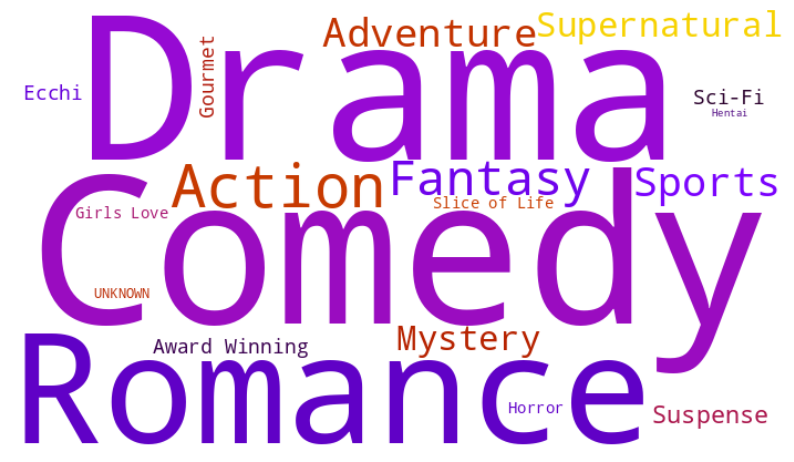

,Name,Genres
12,Tennis no Ouji-sama,Sports
54,Gakuen Alice,"Comedy, Fantasy"
99,Fruits Basket,"Drama, Romance, Supernatural"
100,Fullmetal Alchemist,"Action, Adventure, Award Winning, Drama, Fantasy"
102,Fushigi Yuugi,"Adventure, Fantasy, Romance"


In [ ]:
user_pref = get_user_preferences(random_user, plot=True, verbose=1)
pd.DataFrame(user_pref).head(5)

#Part 3: Recommending Animes for a User

In [ ]:
def get_recommended_animes(similar_users, user_pref, n=10):
    recommended_animes = []
    anime_list = []

    for user_id in similar_users.similar_users.values:
        pref_list = get_user_preferences(int(user_id))
        if not pref_list.empty:  # Check if user has watched any animes
            pref_list = pref_list[~pref_list["Name"].isin(user_pref["Name"].values)]
            anime_list.append(pref_list.Name.values)

    if len(anime_list) == 0:
        print("No anime recommendations available for the given users.")
        return pd.DataFrame()

    anime_list = pd.DataFrame(anime_list)
    sorted_list = pd.DataFrame(pd.Series(anime_list.values.ravel()).value_counts()).head(n)
    # Count the occurrences of each anime in the entire dataset
    anime_count = df['anime_id'].value_counts()

    for i, anime_name in enumerate(sorted_list.index):
        if isinstance(anime_name, str):
            try:
                anime_id = df_anime[df_anime.Name == anime_name].anime_id.values[0]
                english_name = df_anime[df_anime['Name'] == anime_name]['English name'].values[0]
                name = english_name if english_name != "UNKNOWN" else anime_name
                genre = df_anime[df_anime.Name == anime_name].Genres.values[0]
                Synopsis = df_anime[df_anime.Name == anime_name].Synopsis.values[0]
                n_user_pref = anime_count.get(anime_id, 0)  # Get the total count of users who have watched this anime
                recommended_animes.append({
                    "n": n_user_pref,
                    "anime_name": anime_name,
                    "Genres": genre,
                    "Synopsis": Synopsis
                })
            except:
                pass
    return pd.DataFrame(recommended_animes)

In [ ]:
recommended_animes = get_recommended_animes(similar_users, user_pref, n=10)

print('\n> Top recommendations for user: {}'.format(random_user))
recommended_animes


> Top recommendations for user: 78746


,n,anime_name,Genres,Synopsis
0,76710,Fullmetal Alchemist: Brotherhood,"Action, Adventure, Drama, Fantasy","After a horrific alchemy experiment goes wrong in the Elric household, brothers Edward and Alphonse are left in a catastrophic new reality. Ignoring the alchemical principle banning human transmutation, the boys attempted to bring their recently deceased mother back to life. Instead, they suffered brutal personal loss: Alphonse's body disintegrated while Edward lost a leg and then sacrificed an arm to keep Alphonse's soul in the physical realm by binding it to a hulking suit of armor.\n\nThe brothers are rescued by their neighbor Pinako Rockbell and her granddaughter Winry. Known as a bio-mechanical engineering prodigy, Winry creates prosthetic limbs for Edward by utilizing ""automail,"" a tough, versatile metal used in robots and combat armor. After years of training, the Elric brothers set off on a quest to restore their bodies by locating the Philosopher's Stone—a powerful gem that allows an alchemist to defy the traditional laws of Equivalent Exchange.\n\nAs Edward becomes an infamous alchemist and gains the nickname ""Fullmetal,"" the boys' journey embroils them in a growing conspiracy that threatens the fate of the world."
1,70360,Angel Beats!,"Drama, Supernatural","Death is one of many mysteries that has left humanity in the dark since the dawn of time. However, the burning question of what happens to the soul after one dies is soon answered to 17-year-old Yuzuru Otonashi. Waking up with no previous memories in a dimension between life and death, he discovers the unsettling truth of the afterlife. \n\nTaking the form of a high school, this bizarre dimension is designated to shelter those who died unwanted deaths. Feeling wronged by God during their earthly lives, the school's residents have decided to form the Afterlife Battlefront—a rebellious faction determined to oppose their god-like student council president, Kanade ""Angel"" Tachibana. The group's leader, Yuri Nakamura, recruits Otonashi in their fight against Angel in order to take control of their own lives. However, questioning the morality behind their actions, Otonashi takes a step behind the enemy lines to understand the opposing side of their common fate."
2,23967,Kimi no Na wa.,"Award Winning, Drama, Supernatural","Mitsuha Miyamizu, a high school girl, yearns to live the life of a boy in the bustling city of Tokyo—a dream that stands in stark contrast to her present life in the countryside. Meanwhile in the city, Taki Tachibana lives a busy life as a high school student while juggling his part-time job and hopes for a future in architecture.\n\nOne day, Mitsuha awakens in a room that is not her own and suddenly finds herself living the dream life in Tokyo—but in Taki's body! Elsewhere, Taki finds himself living Mitsuha's life in the humble countryside. In pursuit of an answer to this strange phenomenon, they begin to search for one another.\n\nKimi no Na wa. revolves around Mitsuha and Taki's actions, which begin to have a dramatic impact on each other's lives, weaving them into a fabric held together by fate and circumstance."
3,96950,Code Geass: Hangyaku no Lelouch,"Action, Award Winning, Drama, Sci-Fi","In the year 2010, the Holy Empire of Britannia is establishing itself as a dominant military nation, starting with the conquest of Japan. Renamed to Area 11 after its swift defeat, Japan has seen significant resistance against these tyrants in an attempt to regain independence.\n\nLelouch Lamperouge, a Britannian student, unfortunately finds himself caught in a crossfire between the Britannian and the Area 11 rebel armed forces. He is able to escape, however, thanks to the timely appearance of a mysterious girl named C.C., who bestows upon him Geass, the ""Power of Kings."" Realizing the vast potential of his newfound ""power of absolute obedience,"" Lelouch embarks upon a perilous journey as the masked vigilante known as Zero, leading a merciless 

#Content-Based Recommendation

In [ ]:
# Create a TF-IDF vectorizer
tfidf = TfidfVectorizer(stop_words='english')

# Define a generator to compute TF-IDF matrix on the fly
tfidf_matrix_generator = tfidf.fit_transform((genre for genre in df_anime['Genres'].values.astype('U')))

# Compute cosine similarity matrix as a sparse matrix
cosine_sim_sparse = linear_kernel(tfidf_matrix_generator, tfidf_matrix_generator)

In [ ]:
def get_recommendations(title, cosine_sim, df):
    idx = df_anime[df_anime['Name'] == title].index[0]

    # Compute the similarity scores between the anime at the given index and all other animes
    sim_scores = list(enumerate(cosine_sim[idx]))

    # Filter out animes with unknown scores
    valid_scores = [x for x in sim_scores if df_anime.iloc[x[0]]['Score'] != "UNKNOWN"]

    # Sort the valid anime similarity scores based on the cosine similarity and ratings score in descending order
    sorted_scores = sorted(valid_scores, key=lambda x: (x[1], df_anime.iloc[x[0]]['Score']), reverse=True)

    # Get the top 10 similar animes (excluding the anime itself)
    top_animes = [x for x in sorted_scores if x[0] != idx][:10]

    # Extract the indices of the recommended animes
    recommended_indices = [idx for idx, _ in top_animes]
    recommended_animes = df_anime.iloc[recommended_indices][['Name', 'Genres', 'Score']]
    return recommended_animes


In [ ]:
anime_title = 'Kono Subarashii Sekai ni Shukufuku wo!'
recommendations = get_recommendations(anime_title, cosine_sim_sparse, df_anime)
print(f'Recommendations for "{anime_title}":')
recommendations

Recommendations for "Kono Subarashii Sekai ni Shukufuku wo!":


,Name,Genres,Score
14578,Kono Subarashii Sekai ni Shukufuku wo! Movie: ...,"Adventure, Comedy, Fantasy",8.45
11572,Kono Subarashii Sekai ni Shukufuku wo! 2,"Adventure, Comedy, Fantasy",8.27
6241,Doraemon Movie 31: Shin Nobita to Tetsujin Hei...,"Adventure, Comedy, Fantasy",8.14
12451,Kono Subarashii Sekai ni Shukufuku wo! 2: Kono...,"Adventure, Comedy, Fantasy",8.03
502,Slayers Next,"Adventure, Comedy, Fantasy",8.02
1068,Slayers Try,"Adventure, Comedy, Fantasy",7.81
11859,Little Witch Academia (TV),"Adventure, Comedy, Fantasy",7.81
12531,Mahoujin Guruguru (2017),"Adventure, Comedy, Fantasy",7.81
7105,Little Witch Academia,"Adventure, Comedy, Fantasy",7.8
8061,Little Witch Academia: Mahoujikake no Parade,"Adventure, Comedy, Fantasy",7.75


In [ ]:
anime_title = 'One Piece'
recommendations = get_recommendations(anime_title, cosine_sim_sparse, df_anime)
print(f'Recommendations for "{anime_title}":')
recommendations

Recommendations for "One Piece":


,Name,Genres,Score
16617,Bleach: Sennen Kessen-hen,"Action, Adventure, Fantasy",9.07
6456,Hunter x Hunter (2011),"Action, Adventure, Fantasy",9.04
115,Hunter x Hunter,"Action, Adventure, Fantasy",8.41
116,Hunter x Hunter: Original Video Animation,"Action, Adventure, Fantasy",8.31
1574,Naruto: Shippuuden,"Action, Adventure, Fantasy",8.26
19600,Jigokuraku,"Action, Adventure, Fantasy",8.26
118,Hunter x Hunter: Greed Island Final,"Action, Adventure, Fantasy",8.25
23239,Dungeon ni Deai wo Motomeru no wa Machigatteir...,"Action, Adventure, Fantasy",8.24
7799,Magi: The Kingdom of Magic,"Action, Adventure, Fantasy",8.22
14699,One Piece Movie 14: Stampede,"Action, Adventure, Fantasy",8.22
